# Nowcasting confidence in job security using Google Trends
## 1. Dataset presentation
* Necessary libraries are imported below.
* Change provided Dates to Datetime objects to be able to utilize dates (for example, Year-Month format is used for aggregation).
* Periodicity is set as monthly to use statsmodels.

In [70]:
import pandas as pd 
import numpy as np 
import datetime
import helpers
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import statsmodels.formula.api as smf
from statsmodels.tsa.ar_model import AutoReg
from pytrends.request import TrendReq
from scipy.stats import norm
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio


init_notebook_mode(connected=True)
FIGSIZE = (12, 6)

# Import the dataset and change date format
df = pd.read_csv('data/probability_dataset.csv', skiprows = 1).drop(columns = ['DK; NA', 'Unnamed: 11'])
df['Date'] = df.Year.apply(str) + "-" +  df.Month.apply(str)
df.Date = pd.to_datetime(df.Date)
df.set_index('Date', inplace = True)
df.index = pd.DatetimeIndex(df.index).to_period('M') # Set periodicity to monthly
df.drop(columns = ['Month', 'Year'], inplace = False) # Do not show month and year, but keep for aggregation

,0%,1-24%,25-49%,50%,51-74%,75-99%,100%,Mean
Date,,,,,,,,
2004-01,39,27,9,15,3,6,1,21.8
2004-02,42,28,8,11,3,5,2,20.2
2004-03,41,27,11,12,2,4,2,20.1
2004-04,37,29,10,13,3,5,2,21.9
2004-05,37,29,11,11,2,7,2,22.3
...,...,...,...,...,...,...,...,...
2020-06,41,27,12,11,2,4,3,20.7
2020-07,37,27,11,12,3,6,4,23.7
2020-08,38,30,11,10,2,5,3,21.4


In [71]:
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'plotly_mimetype+notebook_connected'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

Respondants were asked: 

"During the next 5 years, what do you think the chances are that you (or
your husband/wife) will lose a job that you wanted to keep ?". 

They were asked to answer an integer from 0 to 100. 

The dataset contains 8 columns. Columns 1 to 7 represent aggregates over certain percentage ranges. The last one is the overall average estimated probability the respondants gave. We will only look at the mean from now on. 

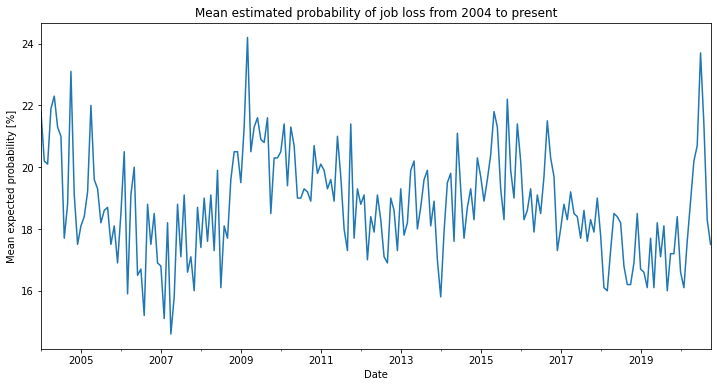

In [36]:
fig, ax = plt.subplots(1, 1, figsize = FIGSIZE) 
df['Mean'].plot()
ax.set_ylabel('Mean expected probability [%]')
ax.set_title('Mean estimated probability of job loss from 2004 to present')
plt.show()

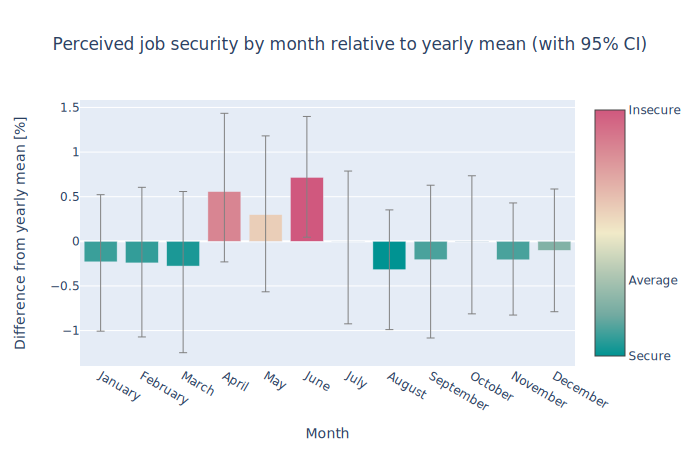

In [73]:
months = [datetime.date(2000, m, 1).strftime('%B') for m in range(1, 13)]

# Compute statistics about the outcome
t = df.Mean.mean() # Overall mean
monthly_mean = df.groupby('Month').apply(np.mean)['Mean'] # Mean by month
# Compute a 95%CI for the monthly mean
monthly_df = df.set_index('Month')
y_error = np.zeros((2, len(months)))
for i in range(1, len(months) + 1):
    l, h = helpers.bootstrap(monthly_df.loc[i].Mean)
    m = np.mean(monthly_df.loc[i].Mean)
    y_error[0,i-1] = m-l
    y_error[1,i-1] = h-m
    

# Make a plot 
plotly_err = dict(type='data',
            symmetric=False,
            array=y_error[0],
            arrayminus=y_error[1], 
            color = 'gray',
            thickness = 1)

fig = go.Figure(
    layout=go.Layout(title=go.layout.Title(text="Perceived job security by month relative to yearly mean (with 95% CI)"),
    xaxis_title="Month", yaxis_title="Difference from yearly mean [%]", title_x=0.5))

n = ['Insecure', 'Average', 'Secure'] # Colorbar labels
v = [max(monthly_mean-t), 0, min(monthly_mean-t)] # Positions of colorbar labels

fig.add_trace(go.Bar(x=months, y=monthly_mean-t,
                marker=dict(color = monthly_mean-t,
                     colorscale='tealrose', 
                            colorbar=dict(thickness = 30, tickvals = v, ticktext = n)), error_y = plotly_err))

fig.write_html("monthly_percentage.html") #To save the plot
fig.show(renderer="svg")


## 2. Baseline model 
We build a baseline auto-regressive model. This is appropriate, because the time series we are modeling can be assumed to depend linearly on previous terms and on a stochastic term. The most reasonable assumption is that values taken on the previous month and the previous year are the most relevant. The dependence on the previous month allows to explain low frequency evolutions (i.e. the probability at a given month depends on the value at the previous month, meaning doesn't change too sharply in general, just like the economic situation usually changes gradually). The dependency on the previous year is important to account for seasonal changes; we have shown above that the probability has a seasonality, on average peaking in April.

Let $y$ denote the mean estimated probability of job loss.
Then, we model: 
$y_t = \beta_0 + \beta_1 y_{t-1} + \beta_12 y_{t-12} + \epsilon_t \tag{1}$

Let's first see if this logical reasoning is correct by testing which lag terms are statistically significant. We want a familiywise Type I error rate of $\alpha$, and use the Šidák correction for the 13 tests (12 potential lag terms and an intercept): 
$\alpha_{Šidák} = 1 - (1-\alpha)^{\frac{1}{13}} \approx 0.004 \tag{2}$
### 2.1 In-sample fit

In [41]:
def in_sample_fit(y, lag_terms, use_intercept = True, alpha = None):
    """ Create a summary of in-sample fit. 
    
    Parameters
    ----------
        y: pd.Series
            Time series to model
        lag_terms: list of integers
            lag terms to include 
        use_intercept: bool, optional
            whether to add an intercept to the regressive model
        alpha: float in (0, 1), optional
            significance level (before correction) - if not provided, will be excluded from summary
            
    """
    if use_intercept: 
        trend_reg = 'c'
    else:
        trend_reg= 'n'
        
    res = AutoReg(df.Mean, lags = lag_terms, trend = trend_reg).fit()
    
    # Create table of parameters
    summary = pd.DataFrame(data = {'Estimate': res.params,
                                      'Standard error': res.bse, 't value': res.tvalues, 
                                      'Pr(>|t|)': res.pvalues})
    rename_dict = {'intercept':'(Intercept)'}
    for k in lag_terms:
        rename_dict['Mean.L{}'.format(k)] = 'lag(y, -{})'.format(k)
        
    summary.rename(index = rename_dict, inplace = True)
    
    # Hypothesis testing
    if alpha is not None:
        alpha_sidak = 1-(1-alpha)**(1/(len(lag_terms) + 1))
        new_col_name = 'At level {:.6f}'.format(alpha_sidak)
        summary[new_col_name] = summary['Pr(>|t|)'] < alpha_sidak
        summary[new_col_name].replace({True: 'Accepted', False: 'Rejected'}, inplace=True)
        
    return summary

lag_terms = np.arange(1, 13) # test all months
in_sample_all = in_sample_fit(df.Mean, lag_terms, use_intercept = True, alpha = 0.05)
in_sample_all

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 



,Estimate,Standard error,t value,Pr(>|t|),At level 0.003938
(Intercept),4.188594,1.648293,2.541171,0.011048,Rejected
"lag(y, -1)",0.343872,0.071557,4.805600,0.000002,Accepted
"lag(y, -2)",0.132966,0.075668,1.757237,0.078877,Rejected
"lag(y, -3)",0.025746,0.074747,0.344442,0.730514,Rejected
"lag(y, -4)",0.106899,0.076705,1.393629,0.163430,Rejected
"lag(y, -5)",-0.081326,0.076377,-1.064800,0.286966,Rejected
"lag(y, -6)",0.230605,0.076654,3.008371,0.002627,Accepted
"lag(y, -7)",0.008414,0.075987,0.110723,0.911836,Rejected
"lag(y, -8)",0.006398,0.075444,0.084809,0.932413,Rejected
"lag(y, -9)",0.070587,0.074967,0.941575,0.346410,Rejected


It turns out that the intercept and the value of from the previous year were not significant. But the value from 6 months ago is. We use these results to modify our model as: 
$y_t = \beta_1 y_{t-1} + \beta_6 y_{t-6} + \epsilon_t \tag{3}$

In [42]:
print("In sample with of the AR model:")
in_sample_all = in_sample_fit(df.Mean, [1, 6], use_intercept = False)
in_sample_all

In sample with of the AR model:


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 



,Estimate,Standard error,t value,Pr(>|t|)
"lag(y, -1)",0.561683,0.053631,10.473151,1.147587e-25
"lag(y, -6)",0.435345,0.053603,8.121725,4.596024e-16


Mean Absolute Error of the AR predictions: 1.1748


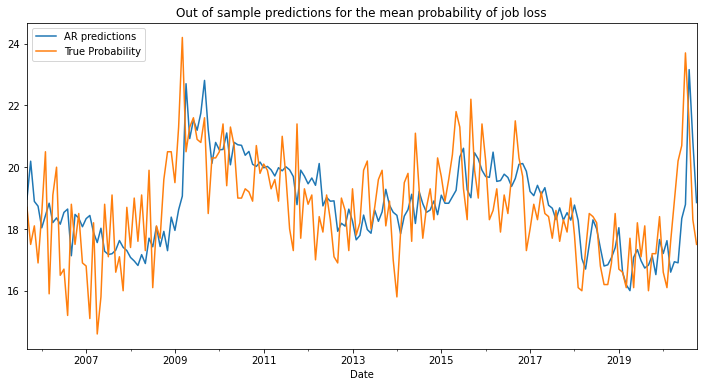

In [43]:
df['Mean_t_1'] = df.Mean.shift(1) 
df['Mean_t_6'] = df.Mean.shift(6)

k = 20 # How to choose k ? Fit gets better the larger k (>= 7) is
# k needs to be large for Trends ot be useful

forecast_start = df.index[k]
for i in range(k, len(df)):    
    mod_base = smf.ols(formula='Mean ~ Mean_t_1 + Mean_t_6', data=df[i-k:i])
    res_base = mod_base.fit()
    df.loc[df.index[i], 'Baseline'] = res_base.predict(df.iloc[i])[0]
    
fig, ax = plt.subplots(1, 1, figsize = FIGSIZE) 
ax.set_title('Out of sample predictions for the mean probability of job loss')
df.Baseline[forecast_start:].plot()
df.Mean[forecast_start:].plot()
ax.legend(['AR predictions', 'True Probability'])

print('Mean Absolute Error of the AR predictions: {:.4f}'.format(helpers.mae(df.Mean, df.Baseline, forecast_start)))

## 3. Using Google Trends
* In this section, we begin to utilize Google Trends features. 
* We try different methods to find different useful Google Trends features.
    * Manual features selection: Manually selected features are chosen. These features are selected by rational thinking(Possible correlations & causations) 
    * Spike and Slab: Features assigned with posterior probabilities, and ones 

In [44]:
trends = pd.read_csv('data/trends.csv', index_col = 'Date')
trends.index = pd.DatetimeIndex(trends.index).to_period('M')

df_full = pd.merge(df, trends, left_index=True, right_index=True)
df_full.tail()

,Month,Year,0%,1-24%,25-49%,50%,51-74%,75-99%,100%,Mean,Mean_t_1,Mean_t_6,Baseline,Crisis
Date,,,,,,,,,,,,,,
2020-06,6,2020,41,27,12,11,2,4,3,20.7,20.2,18.4,18.336999,52
2020-07,7,2020,37,27,11,12,3,6,4,23.7,20.7,16.6,18.794005,36
2020-08,8,2020,38,30,11,10,2,5,3,21.4,23.7,16.1,23.159129,33
2020-09,9,2020,41,33,8,11,2,3,2,18.3,21.4,17.6,20.838315,39
2020-10,10,2020,47,27,8,10,3,3,2,17.5,18.3,18.9,18.854319,37


Mean Absolute Error of the predictions: 1.1668


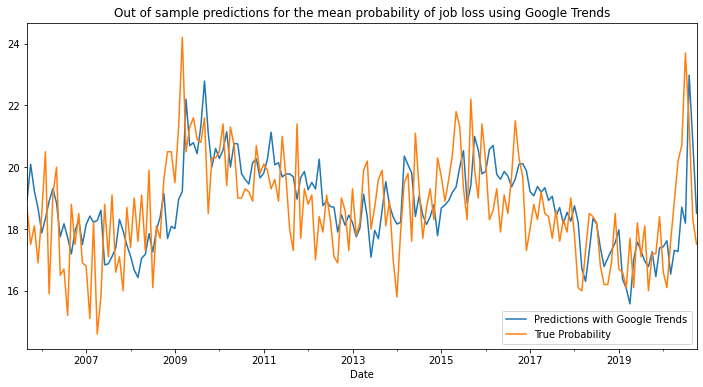

In [45]:
for i in range(k, len(df)):    
    mod_base = smf.ols(formula='Mean ~ Mean_t_1 + Mean_t_6 + Crisis', data=df_full[i-k:i])
    res_base = mod_base.fit()
    df_full.loc[df.index[i], 'Trends'] = res_base.predict(df_full.iloc[i])[0]
    
fig, ax = plt.subplots(1, 1, figsize = FIGSIZE) 
ax.set_title('Out of sample predictions for the mean probability of job loss using Google Trends')
df_full.Trends[forecast_start:].plot()
df_full.Mean[forecast_start:].plot()
ax.legend(['Predictions with Google Trends', 'True Probability'])

print('Mean Absolute Error of the predictions: {:.4f}'.format(helpers.mae(df_full.Mean, df_full.Trends, forecast_start)))

Since Google Trends provides us a various selection of search terms and topics it may be hard to select all of them manually. In order to select a set of topics before running our feature selection algorithm we had to find which topics to give. In order to achive that we used two methods:

1. Intuitively selecting some topics (manually)
2. Using the python module **pytrends**, which has a function called related_topics() which returns related topics for a given search term. We used **Job loss** as the search term

In [46]:
pytrend = TrendReq()
_geo = 'US' # Only in US
_gprop = '' # Default to web searches

# Build payload request to get data from Google trends
start, end = str(df.index[0].to_timestamp()).split(' ')[0], str(df.index[-1].to_timestamp()).split(' ')[0]
_timeframe = '{:s} {:s}'.format(start, end)
pytrend.build_payload(kw_list=['Job loss'],timeframe=_timeframe, geo=_geo,gprop=_gprop)

#Get related topics for "Job loss"
related_topic = pytrend.related_topics()


In [47]:
#Print them as a list
related_topic["Job loss"]["top"]["topic_title"].values

array(['Job', 'Weight loss', 'Employment', 'Retail loss prevention',
       'Job description', 'Insurance', 'Unemployment', 'Salary', 'Income',
       'Wage', 'Mortgage loan', 'Depression', 'Layoff', 'Career',
       'Human nose', 'Statistics', 'Hair loss', 'Rhinoplasty',
       'Coronavirus disease 2019', 'Termination of employment'],
      dtype=object)

In [48]:
#Manually selected topics
kws=["Economy", "Unemployment","Crisis","Loan","Pension"] 
#Merge the related_topic list and manually selected ones
kws = list(set(list(related_topic["Job loss"]["top"]["topic_title"].values) + kws))

Now, let's dive into a little bit about how google trends work. From their FAQ you can find this description : "Each data point is divided by the total searches of the geography and time range it represents to compare relative popularity. Otherwise, places with the most search volume would always be ranked highest.
The resulting numbers are then scaled on a range of 0 to 100 based on a topic’s proportion to all searches on all topics." 

However, Google Trends data has 2 major drawbacks:

1. You can only search for five terms at once
2. It is a relative metric, which means results change according the other terms that are used. And due to drawback 1 you can't search for more than 5 terms.

One possible solution to this problem is using an anchor term, where the term should be always greater than the other search terms and also should be stable. Usually large city names are good anchors, e.g. New York. Then, one can get the result always pairing with this anchor term.

However, finding the right anchor highly depends on other search terms. To automize the process we used Google Trends Anchor Bank (G-TAB) which is developped by EPFL's DLAB. ( You can find more detail in here https://github.com/epfl-dlab/GoogleTrendsAnchorBank)

In [49]:
import gtab
t = gtab.GTAB() 
t.set_options(pytrends_config={"geo": "US", "timeframe": "2004-01-01 2020-12-01"}) # Note that this anchor bank is created locally if you want to use it you also need to create it
t.set_active_gtab("google_anchorbank_geo=US_timeframe=2004-01-01 2020-12-01.tsv")

Using directory '/opt/anaconda3/lib/python3.8/site-packages/gtab'
Active anchorbank changed to: google_anchorbank_geo=_timeframe=2019-01-01 2020-08-01.tsv

Active anchorbank changed to: google_anchorbank_geo=US_timeframe=2004-01-01 2020-12-01.tsv



In [62]:

queries  ={} # Query dictionary 
for kw in kws:
    query = t.new_query(kw) # Get the query for the keyword
    queries[kw] = query

Using /opt/anaconda3/lib/python3.8/site-packages/gtab/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2004-01-01 2020-12-01.tsv
New query 'Depression'
New query calibrated!
Using /opt/anaconda3/lib/python3.8/site-packages/gtab/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2004-01-01 2020-12-01.tsv
New query 'Layoff'
New query calibrated!
Using /opt/anaconda3/lib/python3.8/site-packages/gtab/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2004-01-01 2020-12-01.tsv
New query 'Hair loss'
New query calibrated!
Using /opt/anaconda3/lib/python3.8/site-packages/gtab/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2004-01-01 2020-12-01.tsv
New query 'Coronavirus disease 2019'
New query calibrated!
Using /opt/anaconda3/lib/python3.8/site-packages/gtab/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2004-01-01 2020-12-01.tsv
New query 'Economy'
New query calibrated!
Using /opt/anaconda3/lib/python3.8/site-packages/gtab/output/goo

In [63]:
pytrends_df = pd.DataFrame(index=range(204),columns=["dummy"]) #Create an empty dataframe
pytrends_df.index = queries["Economy"].index.to_period('M') #Make it's index same with gtap queries

for kw in kws: #For every kw in keywords
    query = queries[kw] # Get the respected query
    kwn = kw.replace(" ","_") # Replace white spaces with _ to be able to use in formula
    pytrends_df[kwn] = query["max_ratio"].values # Get the max_ratio value

pytrends_df = pytrends_df.drop(columns = ["dummy"]) # Drop the dummy variable

In [64]:
df_full2 = pd.merge(df, pytrends_df, left_index=True, right_index=True) # Merge the trends with our initial dataframe
df_full2.tail()

,Month,Year,0%,1-24%,25-49%,50%,51-74%,75-99%,100%,Mean,...,Weight_loss,Insurance,Rhinoplasty,Statistics,Job_description,Income,Unemployment,Employment,Mortgage_loan,Loan
2020-06,6,2020,41,27,12,11,2,4,3,20.7,...,51.112455,291.762427,1.976190,41.819281,11.118979,75.894251,466.092812,35.623832,8.424262,149.004471
2020-07,7,2020,37,27,11,12,3,6,4,23.7,...,49.563593,302.568443,2.166667,34.074970,11.336998,82.089700,466.092812,34.074970,9.025995,176.452663
2020-08,8,2020,38,30,11,10,2,5,3,21.4,...,46.465868,291.762427,2.023810,30.977245,11.773037,72.796527,430.239519,32.526108,8.023107,147.043886
2020-09,9,2020,41,33,8,11,2,3,2,18.3,...,43.368143,277.354406,1.857143,37.172694,13.299171,80.540838,358.532932,30.977245,6.819641,119.595694
2020-10,10,2020,47,27,8,10,3,3,2,17.5,...,44.917006,295.364432,2.095238,32.526108,12.209075,78.991976,268.899699,29.428383,7.020218,119.595694


### SPIKE AND SLAB ON PYTRENDS RELATED TOPICS

In order to select which trends we will be using, we implemented a Bayesian method called spike and slab. Spike and slab method produces a posterior probability that a variable enters a regression along with an estimate of that coefficient’s posterior distribution. So with Gibbs sampling it produces inclusion probabilities of feautres. 

For the Bayesian regression : we can describe any linear regression

 $y = \beta X + \epsilon $ 

 as 

 $y \sim N\left(X \beta, \sigma^{2}\right)$

 So now we need a prior $ \beta $, and it need to be a mass et zero. $P(\beta = 0) > 0$

 $\beta_{i}=\xi_{i} \cdot Z_{i}$

$\xi_{i} \sim$ Bernoulli $_{\{0,1\}}\left(p_{i}\right)$

$Z_{i} \sim N(0, \Sigma)$

Now we also need to specify $\Sigma$ for the slab part. For that we used g prior. (https://en.wikipedia.org/wiki/G-prior) which is $\hat{\beta}=\left(X^{T} X\right)^{-1} X^{T} y$ and since $y N\left(X \beta, \sigma^{2}\right)$ we have that
$$
\operatorname{Var}(\hat{\beta})=\left(X^{T} X\right)^{-1} X^{T} \sigma^{2}\left[\left(X^{T} X\right)^{-1} X^{T}\right]^{T}=\sigma^{2}\left(X^{T} X\right)^{-1}
$$

Since $ X^{T} X$ might be not be invertible we also added $$ diag\left (X^{T} X\right) $$. Finally for the  $\Sigma\$ we have 

$\Sigma=\left[(1 / 2) X^{T} X+(1 / 2) \operatorname{diag}\left(X^{T} X\right)\right]^{-1}$


In [39]:
df_full2n = df_full2.dropna()
try:
    df_full2n = df_full2n.drop(columns=["Baseline"])
    df_full2n = df_full2n.drop(columns=["Trends"])
except:
    print("Baseline and Trends already dropped!")


X = np.asanyarray(df_full2n.iloc[:,10:])
y = np.asanyarray(df_full2n.Mean)
def get_model(y, X):
    model = pm.Model()
    #Calculate sigma
    Sigma = .5 * np.matmul(X.T, X)
    Sigma += np.diag(np.diag(Sigma))
    Sigma = np.linalg.inv(Sigma)
    #Sigma = np.identity(43)
    #covMatrix = np.cov(X,bias=True)
    with model:
        xi = pm.Bernoulli('xi', .3, shape=X.shape[1]) #inclusion probability for each variable
        tau = pm.HalfCauchy('tau', 1)
        sigma = pm.HalfNormal('sigma', 10)    
        beta = pm.MvNormal('beta', 0, tau*Sigma , shape=X.shape[1])#Prior for the non-zero coefficients
        mean = pm.math.dot(X, xi * beta) #Deterministic function to map the stochastics to the output
        y_obs = pm.Normal('y_obs', mean,sigma, observed=y) #Data likelihood
    return model

Now let's do Gibbs sampling with our new model.( It throws some error in the beginning but works perfectly)

In [40]:
#Build model
model1 = get_model(y, X)
with model1:
    trace = pm.sample(2000, random_seed = 4816, progressbar = True,tune=1000,chains=1)

/opt/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
ERROR (theano.gof.opt): SeqOptimizer apply <theano.tensor.opt.FusionOptimizer object at 0x7ff9476270a0>
ERROR (theano.gof.opt): Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/theano/scalar/basic.py", line 356, in filter
    raise TypeError(
TypeError: Value cannot accurately be converted to dtype (float64) and allow_downcast is not True

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/theano/gof/opt.py", line 249, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/opt/anaconda3/lib/pyt

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 229 seconds.
There were 1900 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.057713656432593276, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


Below you can find the table with inclusion probabilities. As expected values from previous month and 6 months ago has the highest inclusin probability. Additionally, the search topics **Crisis** and **Loan** also have really high inclusion probabilities.

In [100]:
results = pd.DataFrame({'var': df_full2n.columns[10:], 
                        'inclusion_probability':np.apply_along_axis(np.mean, 0, trace['xi'])
                       })
results.sort_values('inclusion_probability', ascending = False)

,var,inclusion_probability
0,Mean_t_1,1.0000
1,Mean_t_6,1.0000
4,Crisis,0.9995
5,Loan,0.9615
12,Job_description,0.1685
16,Salary,0.1175
23,Hair_loss,0.0730
9,Employment,0.0590
7,Job,0.0450
11,Insurance,0.0400


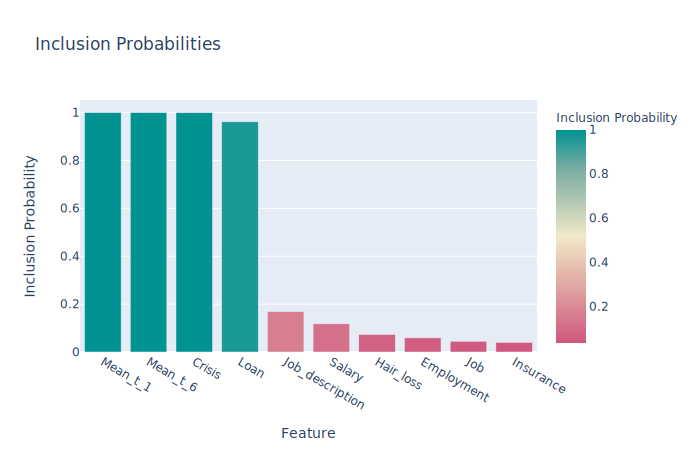

In [74]:
results = {"Feature":["Mean_t_1","Mean_t_6","Crisis","Loan","Job_description","Salary","Hair_loss","Employment","Job","Insurance"]
           ,"Inclusion Probability":[1.0000,1.0000,0.9995,0.9615,0.1685,0.1175,0.0730,0.0590,0.0450,0.0400]}
results = pd.DataFrame(results)
results.columns = ["Feature","Inclusion Probability"]
fig = px.bar(results,title="Inclusion Probabilities", x='Feature', y='Inclusion Probability', color='Inclusion Probability', height=400, color_continuous_scale=px.colors.diverging.Tealrose[::-1])
fig.show(renderer="svg")
#fig.write_html("Spike_slab.html")



### Trends & Regularization


1.   New trends features have been found with help of the Spike and Slab technique. Crisis and Loan have the highest posterior probabilities, and therefore they are going to be used in new fit in addition to the baseline model.
2.  Regularization is essential, which improves the performance of fit drastically. This scenario is depicted in the below four code blocks:

          Regularization_parameter is defined with the equation alpha = 1.1 * np.sqrt(n) * norm.ppf(1 - 0.05 / (2 * p)) by using sqrt_lasso.

          1.   Initial block provides non-regularized baseline  
          2.   Second block provides regularized baseline results.
          3.   Third block contains non-regularized version of the fit.
          4.   Fourth block ensures the regularization.


*   Results are going to be explained below code blocks after witnessing the actual result values.












In [53]:
def  out_of_sample_forecast(df,target_col,formula,regularization,k=20,nparameters=2):
     
    for i in range(k, len(df)):    
        mod_base = smf.ols(formula=formula, data=df[i-k:i])
        if regularization == True:
            alpha = 1.1 * np.sqrt(len(df)) * norm.ppf(1 - 0.05 / (2 * nparameters))/100
            res_base = mod_base.fit_regularized(alpha=alpha, method = "sqrt_lasso")
        else:
            res_base = mod_base.fit()
        df.loc[df.index[i], target_col] = res_base.predict(df.iloc[i])[0]
    fig, ax = plt.subplots(1, 1, figsize = FIGSIZE) 
    ax.set_title('Out of sample predictions for the mean probability of job loss '+target_col)
    df[target_col][forecast_start:].plot()
    df.Mean[forecast_start:].plot()
    ax.legend(['Predictions with '+target_col, 'True Probability'])
    print('Mean Absolute Error of the predictions: {:.4f}'.format(helpers.mae(df.Mean, df[target_col], forecast_start)))



Mean Absolute Error of the predictions: 1.1748


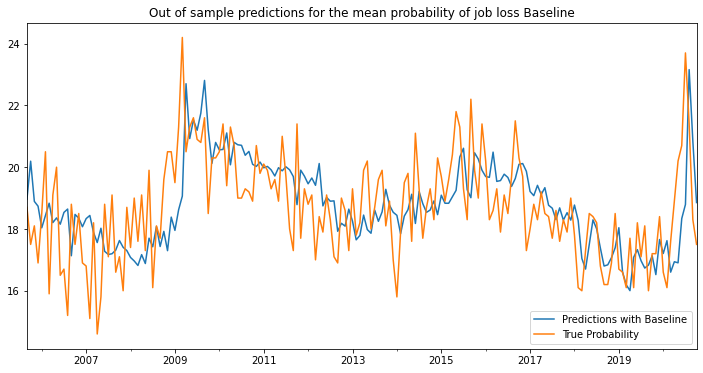

In [54]:
out_of_sample_forecast(df_full2,"Baseline","Mean ~ Mean_t_1 + Mean_t_6",regularization=False)

Mean Absolute Error of the predictions: 1.1914


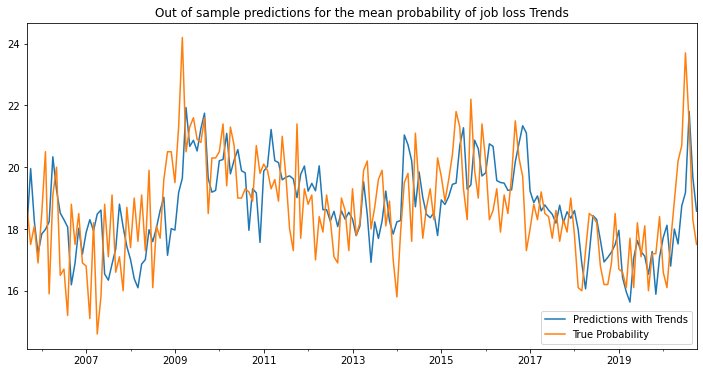

In [142]:
out_of_sample_forecast(df_full2,"Trends","Mean ~ Mean_t_1 + Mean_t_6 + Crisis + Loan",regularization=False,nparameters=4)

Mean Absolute Error of the predictions: 1.1293


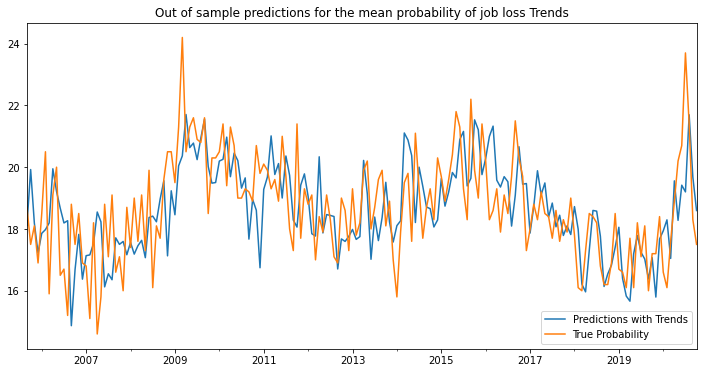

In [143]:
out_of_sample_forecast(df_full2,"Trends","Mean ~ Mean_t_1 + Mean_t_6 + Crisis + Loan",regularization=True,nparameters=4)

In [ ]:
out_of_sample_forecast(df_full2,"Trends","Mean ~ Mean_t_1 + Mean_t_6 + Crisis + Loan",regularization=True,nparameters=4)

* It is clear that regularized fit improves MAE score for both baseline model and trends model.

|Non-regularized baseline MAE | Regularized baseline MAE | Improvement(%)
|:----------------------------: | ------------------------ | --------------
|1.1748 | 1.1430 | 2.7068%

|Non-regularized trends MAE | Regularized trends MAE | Improvement of MAE(%)
|:----------------------------: | ------------------------ | --------------
|1.1914 | 1.1293 | 5.2123%





* In the table below, we compare the non-regularized baseline and non-regularized trends model. We can obviously see that in non-regularized version baseline has a better MAE score compared to non-regularized trends.


|Non-regularized baseline MAE | Non-regularized trends MAE  | Improvement of MAE (%)
|:----------------------------: | ------------------------ | --------------
|1.1748 | 1.1914 | -1.4130%




* With help of regularization situation changes sides, in which trends model has a better MAE score compared to the baseline model. In the table below, we compare the regularized baseline and regularized trends model.

|Regularized baseline MAE | Regularized trends MAE  | Improvement of MAE(%)
|:----------------------------: | ------------------------ | --------------
|1.1430 | 1.1293 | 1.1970%




In [136]:
mae_all_base = np.mean(np.abs(df_full2[k:]["Mean"]-df_full2[k:]["Baseline"]))
mae_all_trends = np.mean(np.abs(df_full2[k:]["Mean"]-df_full2[k:]["Trends"]))
improvement_all = (mae_all_trends - mae_all_base)/mae_all_base*-1

print("Base MAE all time","{:.3}".format(mae_all_base))
print("Trends MAE all time","{:.3}".format(mae_all_trends))
print("Improvement all time :","{:.2%}".format(improvement_all ))

Base MAE all time 1.14
Trends MAE all time 1.13
Improvement all time : 1.20%


### Compare baseline and trends
* We aggregate our data points such that aggregation frequency is 3 months. This is mainly done for visualization purposes, otherwise visualization is hard to comment on.
* Baseline and trends models are compared in this setting, in which their difference is taken with regards to the frequency.

In [137]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
 
result = pd.DataFrame(aef)
#result = result.reset_index()
#result.columns = ["Date","Improvement"]
result.index = result.index.to_timestamp()
result = result.reset_index()
result.columns = ["Date","Improvement(Baseline - Trends MAE)"]


fig = px.bar(result,title="Google Trends Improvement", x='Date', y='Improvement(Baseline - Trends MAE)', color='Improvement(Baseline - Trends MAE)', height=500, width=1000, color_continuous_scale=px.colors.diverging.Tealrose[::-1])
fig.show(renderer="svg")
fig.write_html("trends_improvement.html")
aeb = np.abs(df_full2[k:]["Mean"]-df_full2[k:]["Baseline"])
aet = np.abs(df_full2[k:]["Mean"]-df_full2[k:]["Trends"])
aef = aeb-aet

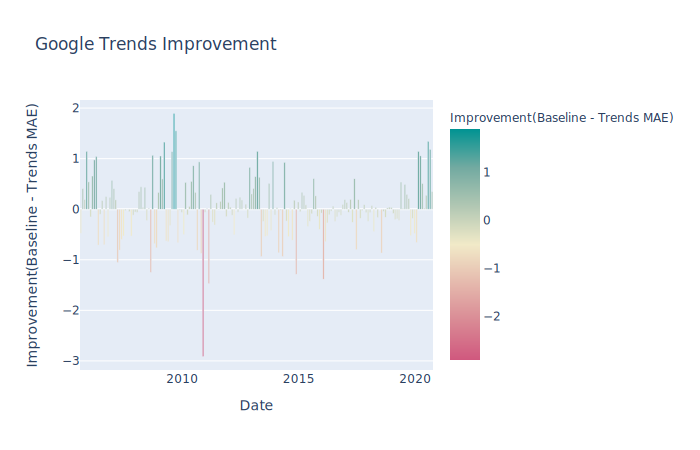

In [180]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
 
result = pd.DataFrame(aef)
#result = result.reset_index()
#result.columns = ["Date","Improvement"]
result.index = result.index.to_timestamp()
result = result.reset_index()
result.columns = ["Date","Improvement(Baseline - Trends MAE)"]


fig = px.bar(result,title="Google Trends Improvement", x='Date', y='Improvement(Baseline - Trends MAE)', color='Improvement(Baseline - Trends MAE)', height=500, width=1000, color_continuous_scale=px.colors.diverging.Tealrose[::-1])
fig.show(renderer="svg")
fig.write_html("trends_improvement.html")


* Positive bars are where we have an improvement in MAE score for trends model compared to baseline model. Although, there are some specific times that baseline model proved to perform better, trends model has overall better performance.
* There are specific time slots where MAE score improves continuosly like the end of plot[2019-2020]. We investigated this improvement, since it up to date and maybe related to Corona.

In [134]:
#Calculate MAE
corona_start = -7 # April 2020
corone_end = len(df_full2) #October 2020 (most recent date)


mae_corona_base = np.mean(np.abs(df_full2[corona_start:corone_end]["Mean"]-df_full2[corona_start:corone_end]["Baseline"]))
mae_corona_trends = np.mean(np.abs(df_full2[corona_start:corone_end]["Mean"]-df_full2[corona_start:corone_end]["Trends"]))
improvement_corona = (mae_corona_trends - mae_corona_base)/mae_corona_base*-1



print("Base MAE during Coronavirus","{:.2}".format(mae_corona_base))
print("Trends MAE during Coronavirus","{:.2}".format(mae_corona_trends))
print("Improvement Coronavirus :","{:.2%}".format(improvement_corona))


Base MAE during Coronavirus 2.3
Trends MAE during Coronavirus 1.6
Improvement Coronavirus : 29.82%


* Above, we investigated MAE scores during Corona virus period as well. We found a huge improvement of MAE(29.82%) in case of trends model rather than the baseline model.